<a href="https://colab.research.google.com/github/stephenebert/Springboard/blob/main/Capstone/step2/%20data-exploration/explore_stable_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA: Stable Diffusion Image → Prompt

This notebook explores the Stable Diffusion dataset:

This notebook tells the story of our Stable Diffusion dataset:

1. **Setup & imports**  
2. **Data loading & preview**  
3. **Quality checks**  
4. **Descriptive statistics & distributions**  
5. **Feature engineering & correlations**  
6. **Token analysis & word cloud**  
7. **Image metadata & visual samples**  

## 1. Setup & Imports

First, we import all the libraries we’ll need.


In [72]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from collections import Counter
import random
from wordcloud import WordCloud

# Make DataFrame outputs and plots look nicer
pd.set_option("display.max_colwidth", 100)
sns.set_style("whitegrid")


## 2. Data Loading & Preview

Load the `prompts.csv` and take a quick peek.

In [75]:
data_dir = Path("/content/Springboard/Capstone/step2/data/stable_diffusion")
print("Files in data folder:", list(data_dir.iterdir()))

csv_path = data_dir / "prompts.csv"
df = pd.read_csv(csv_path)
print("Total samples:", len(df))
df.head()

Files in data folder: [PosixPath('/content/Springboard/Capstone/step2/data/stable_diffusion/sample_submission.csv'), PosixPath('/content/Springboard/Capstone/step2/data/stable_diffusion/images'), PosixPath('/content/Springboard/Capstone/step2/data/stable_diffusion/stable-diffusion-image-to-prompts.zip'), PosixPath('/content/Springboard/Capstone/step2/data/stable_diffusion/prompts.csv')]
Total samples: 7


,imgId,prompt
0,20057f34d,hyper realistic photo of very friendly and dystopian crater
1,227ef0887,"ramen carved out of fractal rose ebony, in the style of hudson river school"
2,92e911621,"ultrasaurus holding a black bean taco in the woods, near an identical cheneosaurus"
3,a4e1c55a9,a thundering retro robot crane inks on parchment with a droopy french bulldog
4,c98f79f71,"portrait painting of a shimmering greek hero, next to a loud frill-necked lizard"


## 3. Quality Checks

Make sure we have no missing prompts and no duplicate image IDs.

In [76]:
print("Missing prompts:", df["prompt"].isna().sum())
print("Duplicate image IDs:", df["imgId"].duplicated().sum())

Missing prompts: 0
Duplicate image IDs: 0


## 4. Descriptive Statistics

Compute summary statistics on prompt length (in tokens).

In [77]:
df["prompt_len"] = df["prompt"].str.split().apply(len)

# Summary stats
stats = df["prompt_len"].describe().to_frame().T
stats.index = ["prompt_len"]
stats

,count,mean,std,min,25%,50%,75%,max
prompt_len,7.0,14.428571,4.314979,9.0,13.0,13.0,15.0,23.0


## 5. Prompt‐Length Distribution

Visualize how long people’s prompts typically are.

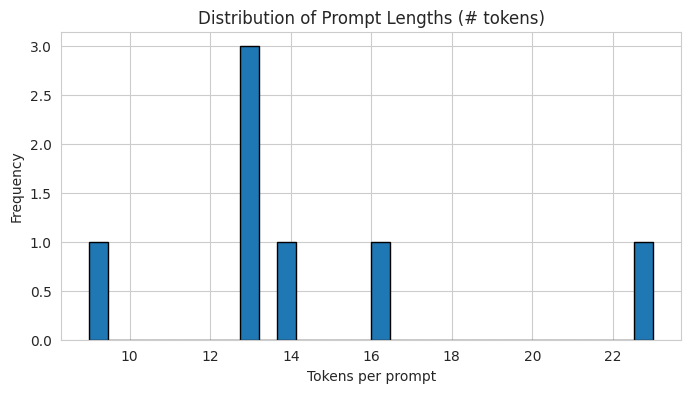

In [78]:
plt.figure(figsize=(8,4))
plt.hist(df["prompt_len"], bins=30, edgecolor="black")
plt.title("Distribution of Prompt Lengths (# tokens)")
plt.xlabel("Tokens per prompt")
plt.ylabel("Frequency")
plt.show()

## 6. Token Frequency

Which words appear most often?  Here’s a bar chart of the Top 20 tokens.

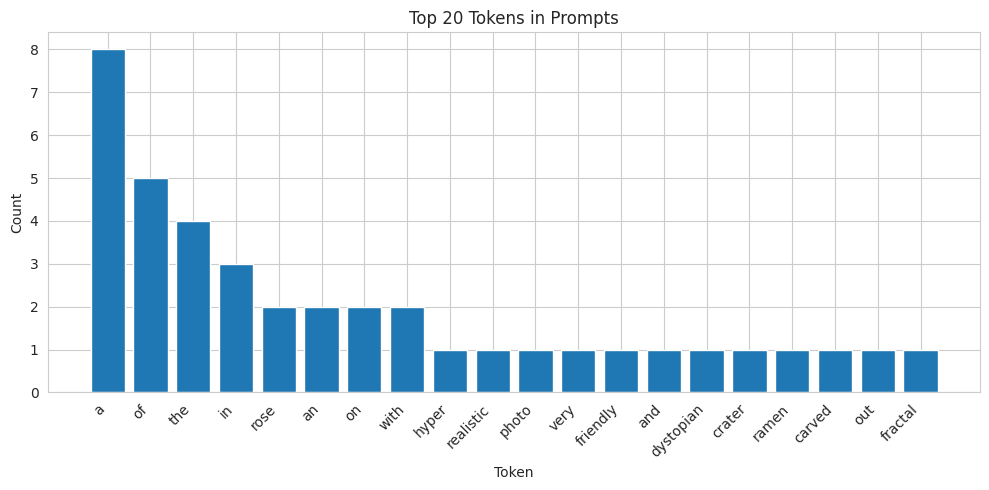

In [79]:
tokens = Counter(
    t.lower().strip(".,!?-")
    for prompt in df["prompt"]
    for t in prompt.split()
)
tf_df = pd.DataFrame(tokens.most_common(20), columns=["token","count"])

plt.figure(figsize=(10,5))
plt.bar(tf_df["token"], tf_df["count"])
plt.xticks(rotation=45, ha="right")
plt.title("Top 20 Tokens in Prompts")
plt.xlabel("Token")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


## 7. Feature Engineering & Correlations

Add two features: character count and unique-token count and see how they correlate.


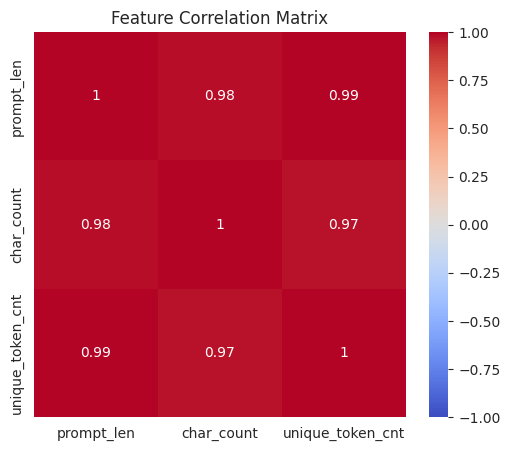

In [80]:
df["char_count"]       = df["prompt"].str.len()
df["unique_token_cnt"] = df["prompt"].str.split().apply(lambda ws: len(set(ws)))

num_feats = df[["prompt_len","char_count","unique_token_cnt"]]
corr = num_feats.corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix")
plt.show()


## 8. Extremes: Shortest & Longest Prompts

Inspect the 5 shortest and 5 longest prompts for any anomalies.

In [81]:
print("5 shortest prompts:\n",
      df.nsmallest(5, "prompt_len")[["imgId","prompt","prompt_len"]], "\n")

print("5 longest prompts:\n",
      df.nlargest(5, "prompt_len")[["imgId","prompt","prompt_len"]])


5 shortest prompts:
        imgId  \
0  20057f34d   
2  92e911621   
3  a4e1c55a9   
4  c98f79f71   
1  227ef0887   

                                                                               prompt  \
0                         hyper realistic photo of very friendly and dystopian crater   
2  ultrasaurus holding a black bean taco in the woods, near an identical cheneosaurus   
3       a thundering retro robot crane inks on parchment with a droopy french bulldog   
4    portrait painting of a shimmering greek hero, next to a loud frill-necked lizard   
1         ramen carved out of fractal rose ebony, in the style of hudson river school   

   prompt_len  
0           9  
2          13  
3          13  
4          13  
1          14   

5 longest prompts:
        imgId  \
6  f27825b2c   
5  d8edf2e40   
1  227ef0887   
2  92e911621   
3  a4e1c55a9   

                                                                                                prompt  \
6  Kaggle employee Phil at

## 8. Extremes: Shortest & Longest Prompts

Inspect the 5 shortest and 5 longest prompts for any anomalies.

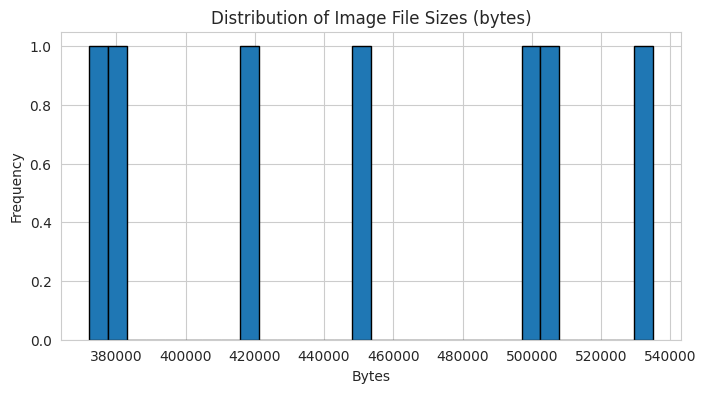

In [82]:
sizes = [os.path.getsize(data_dir/"images"/f"{img}.png") for img in df["imgId"]]
pd.Series(sizes).describe().to_frame("byte_size")

plt.figure(figsize=(8,4))
plt.hist(sizes, bins=30, edgecolor="black")
plt.title("Distribution of Image File Sizes (bytes)")
plt.xlabel("Bytes")
plt.ylabel("Frequency")
plt.show()


## 10. Word Cloud of Prompts

A word cloud gives a quick, high‐level view of the most frequent tokens.


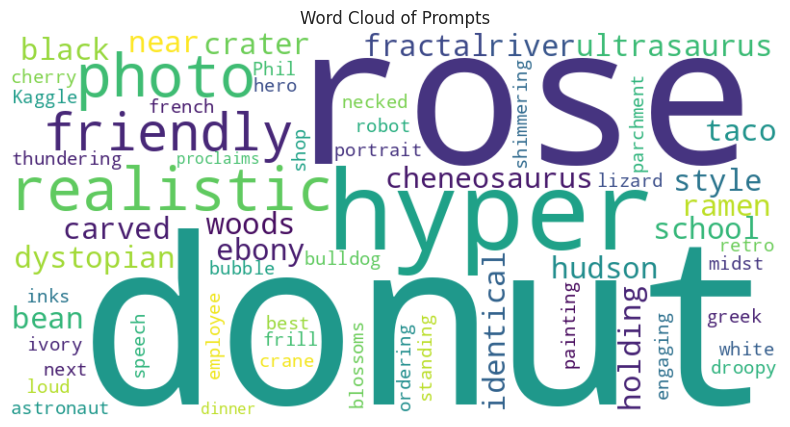

In [83]:
text = " ".join(df["prompt"])
wc = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Prompts")
plt.show()


## 11. Sample Image→Prompt Pairs

Finally, let’s eyeball a few random examples to ensure text ↔ image alignment.


Example #1: Kaggle employee Phil at a donut shop ordering all the best donuts, with a speech bubble that proclaims "Donuts. It's what's for dinner!"



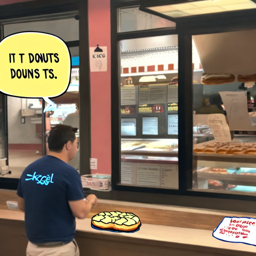


--------------------------------------------------------------------------------

Example #2: ultrasaurus holding a black bean taco in the woods, near an identical cheneosaurus



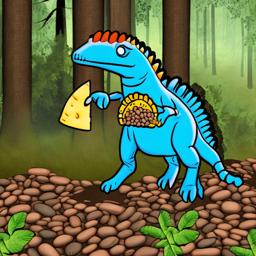


--------------------------------------------------------------------------------

Example #3: ramen carved out of fractal rose ebony, in the style of hudson river school



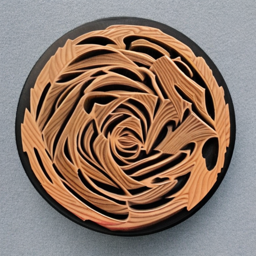


--------------------------------------------------------------------------------

Example #4: a thundering retro robot crane inks on parchment with a droopy french bulldog



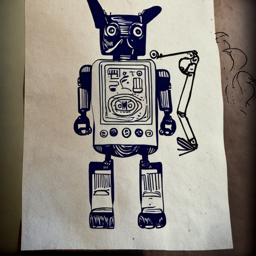


--------------------------------------------------------------------------------

Example #5: hyper realistic photo of very friendly and dystopian crater



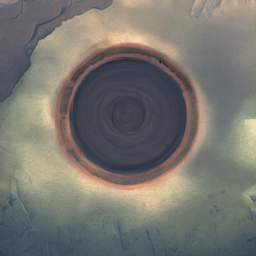


--------------------------------------------------------------------------------



In [84]:
samples = df.sample(5, random_state=0)
for i, row in enumerate(samples.itertuples(index=False), start=1):
    print(f"Example #{i}: {row.prompt}\n")
    display(Image.open(data_dir/"images"/f"{row.imgId}.png").resize((256,256)))
    print("\n" + "-"*80 + "\n")


---

# Conclusion

Our EDA has verified data quality, uncovered prompt‐length patterns, highlighted common tokens, explored feature relationships, and confirmed image‐prompt alignment. We are now ready to proceed to modeling!
